# II - Gradient-free optimization with control points

As a reference, we optimize the air gap of the inductor using the differential evolution algorithm from `scipy`.

In [1]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

First, we set up the number of control points (the more control points, the longer the optimization).

In [2]:
##############################################
NControlPoints = 10 # can be changed up to 20
##############################################
print(f"{NControlPoints = }")

NControlPoints = 10


___________________________
## 1 - Geometry and meshing

Then, we define the inductor geometry and generate the mesh.

In [3]:
# Geometric parameters
lz = 1e-2               # z-thickness of the inductor  
s = 4                   # symmetry factor (model 1/4th of the total space)

# Mesh generation
airgap = 4.11e-3 * np.ones(NControlPoints)              # Array of y-coordinates of control points along the airgap
maxh = 2e-3                                             # Maximum size of mesh element
mesh, p1, p2 = gen_meshN(airgap, maxh)                  # Generate the mesh and return the coordinates of control points on the first and second leg
xAirgaps = [p[0] for p in p1] + [p[0] for p in p2]      # Extract the x-coordinates of the control points

# Define the characteristics functions
XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})
materials_regions = 1 * XiAir + 2 * XiCoil + 3 * XiCore

# Draw the geometry and mesh
Draw(materials_regions, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

___________________________
## 2 - State problem (time-harmonic magnetics)

### 2.a - Parameters definition

We describe the magnetic permeabilities and the source currents.

In [4]:
# Electric current (assumed sinusoidal)
f = 5e4                                                         # Working frequency (Hz)
omega = 2 * np.pi * f                                           # rad/s
nb_turn = 200                                                   # Number of turn in the coil (no unit)
I = 2                                                           # Amplitude of the source current (A)
j = nb_turn / 2 * I / (ngs.Integrate(XiCoil, mesh)) * XiCoil    # Amplitude of the source current density  (A/m²)

# Magnetic permeabilities
mu0 = 4e-7 * np.pi                                              # Void permeability (H/m)
mur = 1000                                                      # Relative permeability of iron (no unit)
mu_iron = mur * mu0                                             # Iron permeability (H/m)
delta = 0.1                                                     # Loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0                             # Complex permeability of the coil

### 2.b - Definition of the time-harmonic magnetics problem

Then we can write the weak formulation and solve the following problem :
$$\text{Find } \underline{a_h} \in H := \{\underline{a} \in H^1(\Omega) |\, \underline{a} = 0 \text{ on } \Gamma_D\} \quad \text{ s.t. } \quad
    \forall \underline{v} \in H, \int_\Omega \underline{\nu_h} (\nabla \underline{a_h}) \cdot (\nabla \underline{v})^* \,\mathrm{d}x = \int_{\Omega_{c, h}} j \underline{v}^* \, \mathrm{d}x. $$

In [5]:
def magWeakFormComplex(ah : ngs.FESpace.TrialFunction, 
                       v  : ngs.FESpace.TestFunction
                       ) -> tuple[ngs.BilinearForm, ngs.LinearForm]:
    """Return the sybolic weak form of the magnetic problem, 
    i.e, bilinear and linear forms (not assembled yet)."""

    # Bilinear form (transmission)
    bf =  1 / mu_iron * ngs.grad(ah) * ngs.grad(v) * ngs.dx("core")
    bf += 1 / mu_coil * ngs.grad(ah) * ngs.grad(v) * ngs.dx("coil")
    bf += 1 / mu0 * ngs.grad(ah) * ngs.grad(v) * ngs.dx("air")

    # Linear form (source)
    lf = j * v * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh : ngs.Mesh
                      ) -> tuple[ngs.GridFunction, ngs.la.BaseMatrix]:
    """ Solve the time-harmonic magnetics problem """

    # Definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|domainVert", complex=True)
    a, v = fes.TnT()

    # Definition of weak form
    bf, f = magWeakFormComplex(a, v)

    # Assembly
    K = ngs.BilinearForm(bf).Assemble()
    F = ngs.LinearForm(f).Assemble()

    # Solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs())
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation

# Example :
state, Kinv = solveStateComplex(mesh)
Draw(state.real, mesh, radius=0.02, settings = {"Objects" : { "Wireframe" : False }})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 2.c - Definition of the post-processed quantities

We define the AC losses and inductance :
$$
\begin{array}{lcl}
P(\underline{a}) &=& \displaystyle s l_z  \pi f \int_{\Omega_c} \text{Im} \left( \frac{1}{\underline{\mu_c}} \right ) |\nabla \underline{a}|^2 \;\mathrm{d}x,\\
L(\underline{a}) &=& \displaystyle \frac{s l_z}{I^2} \int_\Omega \text{Re} \left( \underline{\nu} \right) |\nabla \underline{a}|^2 \;\mathrm{d}x. \\
\end{array}$$


In [6]:
def L(state : ngs.GridFunction, 
      mesh : ngs.Mesh
      ) -> float:
    """ Compute inductance from the time-harmonic solution """
    nu = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (I**2) * ngs.Integrate(nu.real * ngs.Norm(ngs.grad(state)) ** 2, mesh)

def P(state : ngs.GridFunction,
      mesh : ngs.Mesh
      ) -> float:
    """ Compute AC losses in the conductor from the time-harmonic solution """
    nu = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(nu.imag * ngs.Norm(ngs.grad(state)) ** 2, mesh)

# Example :
print(f"Inductance : {L(state, mesh) *1000:.3} mH")
print(f"Losses : {P(state, mesh):.3} W")

Inductance : 1.0 mH
Losses : 13.2 W


___________________________
## 3 - Optimization

### 3.a - `scipy` wrapper
We first define wrappers of the objective function (the losses) and the constraint (the inductance value). We have to set a tolerance for the equality constraint, that we chose to be $\pm5\%$.
Also, we want to avoid a sharp corner at the symmetry axis, so we impose the first and second control point to have the same $y$-coordinate.

In [7]:
# Initialization
FEM_counter, losses_list, x_airgap_list = [0], [], []

# Wrappers
def scipy_obj(x, maxh = 4e-3):
    """ Scipy wrapper to the objective function to minimize """
    FEM_counter[0] += 1                      # Increment at each evaluation
    if FEM_counter[0] % 100 == 0:            # print every 100 function calls
        print(f"{FEM_counter[0]} finite element evaluations.")
    # impose dy/dx = 0 at the symmetry
    x_airgap = [x[0]] + list(x)
    mesh, _, _ = gen_meshN(x_airgap, maxh)
    state, _ = solveStateComplex(mesh)
    return P(state, mesh)

def scipy_const(x, maxh = 4e-3):
    """ Scipy wrapper to the constraint to respect """
    FEM_counter[0] += 1                      # Increment at each evaluation 
    if FEM_counter[0] % 100 == 0:            # print every 100 function calls
        print(f"{FEM_counter[0]} finite element evaluations.")
    # impose dy/dx = 0 at the symmetry
    x_airgap = [x[0]] + list(x)
    mesh, _, _ = gen_meshN(x_airgap, maxh)
    state, _ = solveStateComplex(mesh)
    # It is probably possible to compute objective and constraint with only 1 FEM evaluation,
    # which is not done here for simplicity
    return L(state, mesh) - 1e-3

def callback(intermediate_result):
    losses_list.append(intermediate_result.fun)
    x_airgap_list.append(intermediate_result.x)

# Examples:
print(f" P = {scipy_obj([1e-3,2e-3,3e-3], maxh = 4e-3):.2f} W")
print(f" L-L0 = {1000*scipy_const([1e-3,2e-3,3e-3], maxh = 4e-3):.2f} mH")

 P = 20.92 W
 L-L0 = 1.23 mH


### 3.b - Optimization setup
We then setup the constraints. We can't easily impose a rigorous equality constraint with differential evolution algorithm since an infinite penalty is attributed to solutions violating the contraint. So, we allow for a $\pm+\%$ violation of the $L=1mH$ constraint.

In [8]:
# Constraints setup
from scipy.optimize import NonlinearConstraint, Bounds
nlc = NonlinearConstraint(scipy_const,-5e-5,5e-5) # constraint on the inductance
bnds = Bounds(5e-4*np.ones(NControlPoints-1), 7.2e-3*np.ones(NControlPoints-1)) # air gap bounds

Differential evolution is a popular and highly customizable algorithm, as illustrated below. Our goal is to keep the simplest, yet representative, approach to the gradient-free method; therefore, we leave most parameters at their default values and only set the convergence-related parameter to reasonable values. Clearly, there is room for improvement (feel free to run the code with your own parameters).

In [9]:
from scipy.optimize import differential_evolution
help(differential_evolution)

Help on function differential_evolution in module scipy.optimize._differentialevolution:

differential_evolution(
    func,
    bounds,
    args=(),
    strategy='best1bin',
    maxiter=1000,
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=None,
    callback=None,
    disp=False,
    polish=True,
    init='latinhypercube',
    atol=0,
    updating='immediate',
    workers=1,
    constraints=(),
    x0=None,
    *,
    integrality=None,
    vectorized=False
)
    Finds the global minimum of a multivariate function.

    The differential evolution method [1]_ is stochastic in nature. It does
    not use gradient methods to find the minimum, and can search large areas
    of candidate space, but often requires larger numbers of function
    evaluations than conventional gradient-based techniques.

    The algorithm is due to Storn and Price [2]_.

    Parameters
    ----------
    func : callable
        The objective function to be minimized. Must be 

### 3.c - Optimization loop

In [10]:
result = differential_evolution(
    func = scipy_obj,
    bounds=bnds,
    maxiter=100,
    popsize=15,
    tol = 0.1,      
    atol= 0.1,
    seed=0, # for reproducibility
    disp=True,
    polish=False,  
    constraints = nlc,
    callback=callback
)
x_airgap_opt = [result.x[0]] + list(result.x)

100 finite element evaluations.
200 finite element evaluations.
differential_evolution step 1: f(x)= 9.468208496437436
300 finite element evaluations.
400 finite element evaluations.
differential_evolution step 2: f(x)= 9.468208496437436
500 finite element evaluations.
600 finite element evaluations.
differential_evolution step 3: f(x)= 9.468208496437436
700 finite element evaluations.
differential_evolution step 4: f(x)= 9.157546931414766
800 finite element evaluations.
900 finite element evaluations.
differential_evolution step 5: f(x)= 8.460779186030912
1000 finite element evaluations.
1100 finite element evaluations.
differential_evolution step 6: f(x)= 8.460779186030912
1200 finite element evaluations.
1300 finite element evaluations.
differential_evolution step 7: f(x)= 8.460779186030912
1400 finite element evaluations.
1500 finite element evaluations.
differential_evolution step 8: f(x)= 8.460779186030912
1600 finite element evaluations.
differential_evolution step 9: f(x)= 8.39

__________
## 4 - Results

### 4-a. Design

In [12]:
mesh_opt, _, _ = gen_meshN(x_airgap_opt)
Draw(materials_regions, mesh_opt, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### 4-b. Optimization performances

We recompute the performances of the optimized design (AC losses & inductance) and print the number of objective function and FEM evaluations.

In [15]:
state_opt, _ = solveStateComplex(mesh_opt)
print(f"AC Losses = {P(state_opt, mesh_opt) : .3f} W")
print(f"Inductance = {L(state_opt, mesh_opt)*1000 : .3f} mH")
print("Number of objective function evaluations = ", result.nfev)
print("Number of FEM evaluations (objective + constraints) = ", FEM_counter[0])

AC Losses =  8.127 W
Inductance =  1.023 mH
Number of objective function evaluations =  675
Number of FEM evaluations (objective + constraints) =  3535


### 4-c. Evolution through the optimization

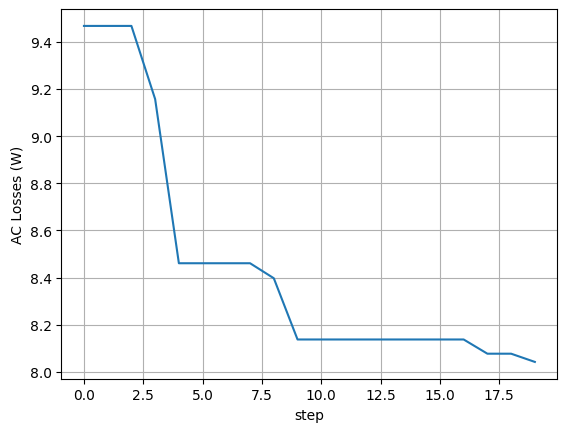

In [16]:
# Convergence of objective function
plt.plot(losses_list)
plt.xlabel("step")
plt.ylabel("AC Losses (W)")
plt.grid()
plt.show()

In [28]:
# Animation
for i in range(len(x_airgap_list)):
    x_opt =  [x_airgap_list[i][0]] + list(x_airgap_list[i])
    mesh, _, _ = gen_meshN(x_opt)
    if i==0:
        scene = Draw(materials_regions, mesh, radius=0.02)
    else:
        scene.Redraw(materials_regions, mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…